# TODO plot distance calls as duration vs amplitude 
# grab wav files to listen to
# males have 2 DCs?
# tets vs stacks? principled
# do mps
# cluster per bird
# density function to smooth histograms of response times
## KDE 

In [1]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
from scipy.optimize import curve_fit
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
# from soundsig.sound import BioSound 
# from soundsig.sound import WavFile


# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


In [2]:
# base_folder = '/Users/williamwood/Documents/Sound_Localization/for_soundsep/14-38-03_18-07-2023' # old folder
base_folder = "/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/"
fs = 48000 # this comes from the wav files, so unless you load them, you need to know this
# Sound_Localization/for_soundsep/7_18_23__09_29_44'

# file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
file_name = os.path.join(base_folder,'spec_results', 'segments.csv')
# file_name = os.path.join(base_folder,'_appdata','save','segments_exclude_short_gaps.csv')

print(file_name)

df = pd.read_csv(file_name, sep=',',header=0, index_col=0)        
print(f'Length of dataframe: {len(df)}')
print(f'Column names: {df.columns}')
print(f'Tags: {df["Tags"].unique()}')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/spec_results/segments.csv
Length of dataframe: 4344
Column names: Index(['SourceName', 'SourceChannel', 'StartIndex', 'StopIndex', 'Tags',
       'cluster', 'coords'],
      dtype='object')
Tags: ['["tet"]' '["hat"]' '["3"]' '["call"]' '["DC"]' '["WF"]' '["-2"]' '["8"]'
 '["2"]']


In [3]:
df

,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords
Unnamed: 0,,,,,,,
0,BroGre1354M,0,705034,709502,"[""tet""]",0.0,[11.813441 10.158026 8.204752]
1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.289108 8.867108 3.8716762]
2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[9.031709 7.9875793 2.4193041]
3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.432616 8.651451 3.9261248]
4,BroGre1354M,0,910549,913839,"[""tet""]",4.0,[10.93499 7.944698 0.92982405]
...,...,...,...,...,...,...,...
4339,WhiWhi1541M,3,297302736,297305283,"[""tet""]",4.0,[12.446056 7.7917695 2.9063237]
4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.918158 10.1539955 3.8789632]
4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[14.02288 10.04855 4.029904]


In [4]:
df['StartIndex'][0]/fs
# df['Tags'] = df['Tags'].apply(lambda x: x[2:-2]) # old technique doesn't work for all
# df.loc[df['Tags'] == '','Tags'] = 'tet' # replace empty tags with 'tet' (not perfect but ok)
df['Bird_ID'] = df['SourceName']
df['StartIndex_in_sec'] = df['StartIndex']/fs
df['EndIndex_in_sec'] = df['StopIndex']/fs

# make a new df column that is the length of the segment in seconds
df['length'] = (df['StopIndex']-df['StartIndex'])/fs

# print(df['Tags'].unique())
print(df['Bird_ID'].unique())
print(f'Columns: {df.columns}')
print(df[0:10])

['BroGre1354M' 'BluGre1214F' 'WhiWhi1541M' 'WhiWhi6607F']
Columns: Index(['SourceName', 'SourceChannel', 'StartIndex', 'StopIndex', 'Tags',
       'cluster', 'coords', 'Bird_ID', 'StartIndex_in_sec', 'EndIndex_in_sec',
       'length'],
      dtype='object')
             SourceName  SourceChannel  StartIndex  StopIndex     Tags  \
Unnamed: 0                                                               
0           BroGre1354M              0      705034     709502  ["tet"]   
1           BluGre1214F              2      739121     741816  ["tet"]   
2           BluGre1214F              2      773851     776369  ["hat"]   
3           BluGre1214F              2      844891     848558  ["tet"]   
4           BroGre1354M              0      910549     913839  ["tet"]   
5           BluGre1214F              2      915664     917825  ["tet"]   
6           BroGre1354M              0      938688     943405  ["tet"]   
7           BluGre1214F              2      955388     958960  ["tet"]   
8

In [5]:
print(df['Tags'].unique())

# 

['["tet"]' '["hat"]' '["3"]' '["call"]' '["DC"]' '["WF"]' '["-2"]' '["8"]'
 '["2"]']


In [6]:
# now I want to sort the long tets from the short tets- the long tets are actually distance calls.
# ideally I would also use spectral features to do this, but my df doesn't have any spectral features.
# I should be able to get them from the other dataframe, we just have to be careful about the indices lining up

# 

spect_df_name = os.path.join(base_folder,'vocSelTableAmp.h5')
spect_df = pd.read_hdf(spect_df_name)

# read npy file
spectrograms = np.load(os.path.join(base_folder,'spec_results','spectrograms.npy'))
# spectrograms = read(os.path.join(base_folder,'spec_results','spectrograms.npy'))
spectrograms.shape

(4344, 101, 100)

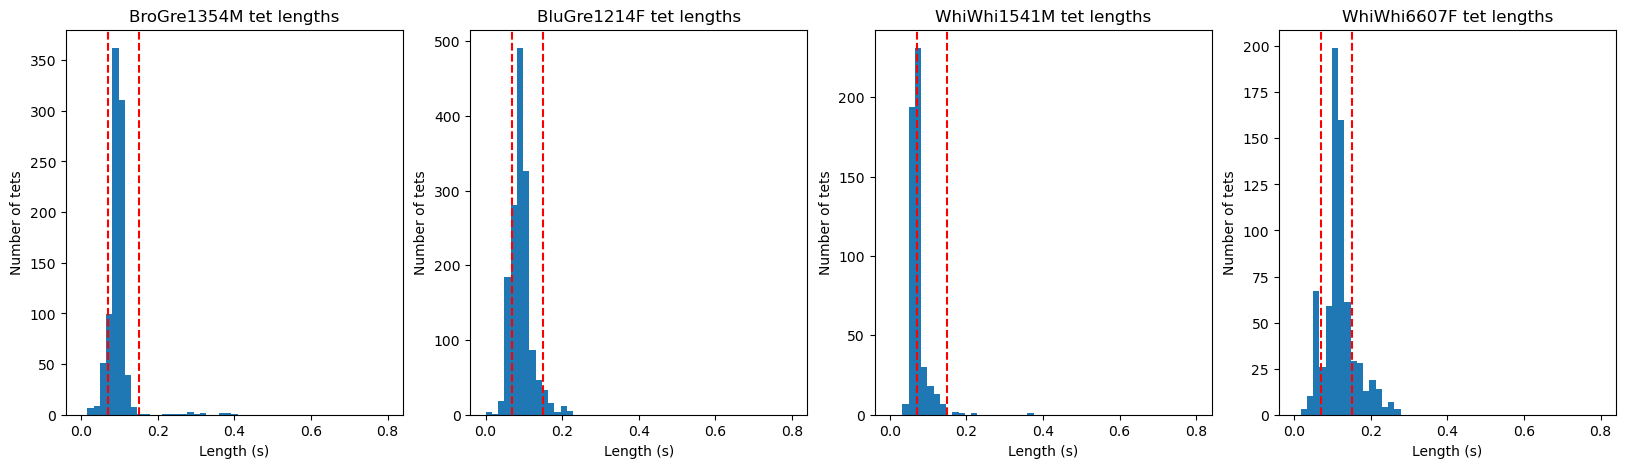

In [7]:

# what is the average length of a tet for each bird? Actually plot the distribution of tet lengths for each bird
# make a dictionary to hold the lengths of tets for each bird
all_tet_lengths = list()
bird_tet_lengths = dict()
for bird in df['Bird_ID'].unique():
    tet_lengths = list()
    for i in df.index:
        if df['Bird_ID'][i] == bird:
            if df['Tags'][i] == '["tet"]':
                tet_lengths.append(df['length'][i])
                all_tet_lengths.append(df['length'][i])
                # if df['length'][i] > 0.15:
                #     print(f'Long tet: {df["length"][i]}')
    bird_tet_lengths[bird] = tet_lengths

# make bins for histogram so that we can plot the distribution of tet lengths on the same axis
bins = np.linspace(0,0.8,50)
# plot the distribution of tet lengths for each bird
# let's put it all in a subplot
# draw a vertical line at 0.15 s and 0.075 s
fig, axs = plt.subplots(1, len(df['Bird_ID'].unique()), figsize=(20,5))
for bird in df['Bird_ID'].unique():
    ax = axs[df['Bird_ID'].unique().tolist().index(bird)]
    ax.hist(bird_tet_lengths[bird], bins=bins)
    ax.axvline(x=0.15, color='r', linestyle='--')
    ax.axvline(x=0.07, color='r', linestyle='--')
    ax.set_title(f'{bird} tet lengths')
    ax.set_xlabel('Length (s)')
    ax.set_ylabel('Number of tets')
plt.show()

    # plt.hist(bird_tet_lengths[bird], bins=bins)
    # plt.title(f'{bird} tet lengths')
    # plt.xlabel('Length (s)')
    # plt.ylabel('Number of tets')
    # plt.show()

Text(0.5, 1.0, 'All tet lengths')

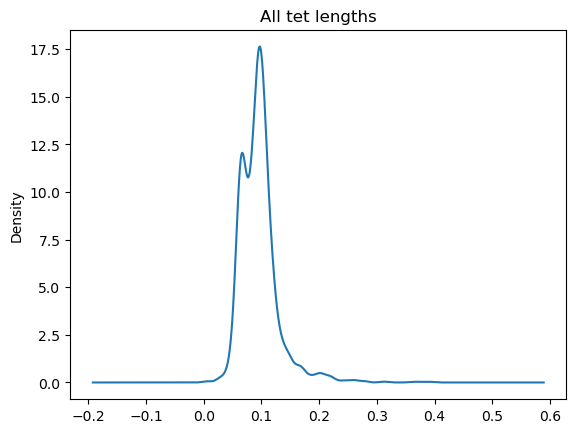

In [8]:
# let's plot the distribution of all tet lengths as a kde
s = pd.Series(all_tet_lengths)
# print(s.describe())
s.plot.kde()
plt.title('All tet lengths')

Text(0, 0.5, 'Density')

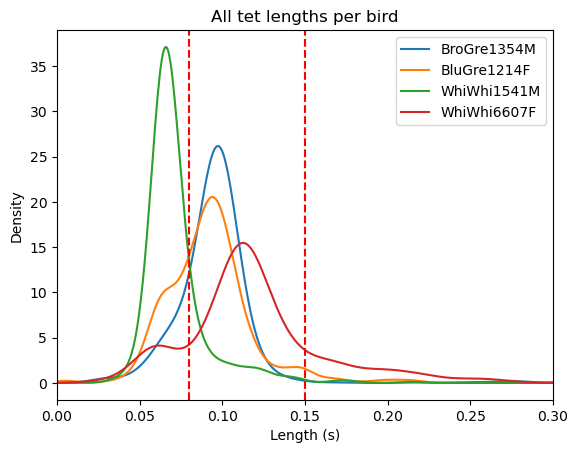

In [9]:
short_tet_thresh = 0.08
long_tet_thresh = 0.15
# now let's plot the distribution of all tet lengths per bird as a kde
# first let's put them in a df
tet_lengths_df = pd.DataFrame()
for bird in df['Bird_ID'].unique():
    s = pd.Series(bird_tet_lengths[bird])
    tet_lengths_df[bird] = s
tet_lengths_df.plot.kde(xlim=(0,0.3))
# put a vertical line at short_tet_thresh and long_tet_thresh
plt.axvline(x=long_tet_thresh, color='r', linestyle='--')
plt.axvline(x=short_tet_thresh, color='r', linestyle='--')
plt.title('All tet lengths per bird')
plt.xlabel('Length (s)')
plt.ylabel('Density')


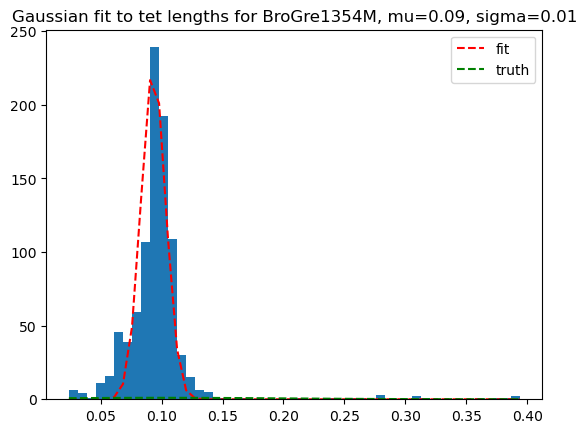

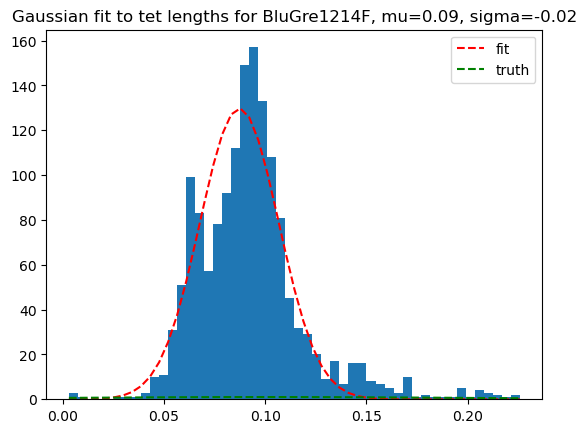

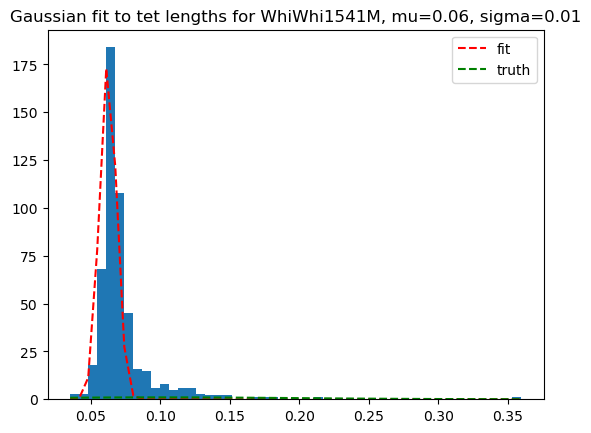

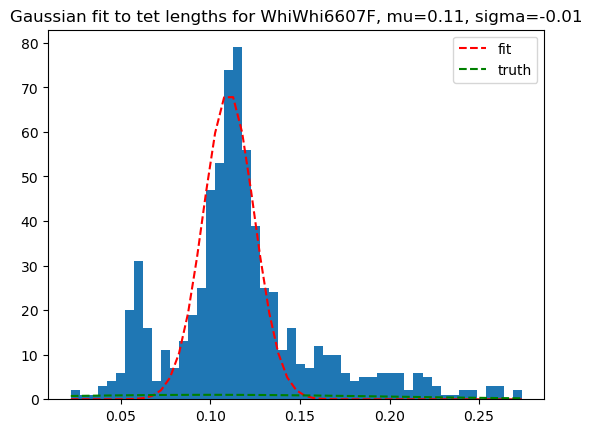

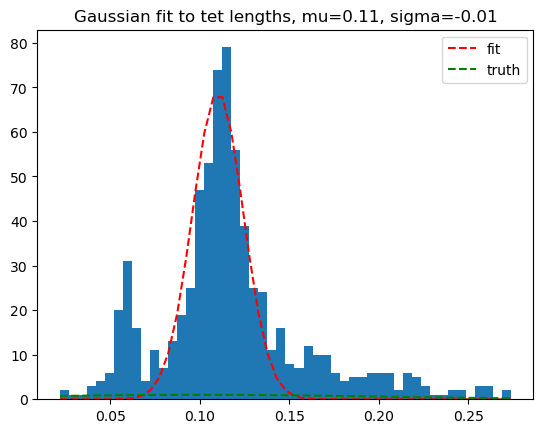

In [10]:
# model the distribution of tet lengths for each bird
# I will use a gaussian mixture model to do this
# I will use the scipy.optimize.curve_fit function to do this
def gaussian(x, amp, mu, sig):
    return amp*np.exp(-(x-mu)**2/(2*sig**2))

def bimodal(x, amp1, mu1, sig1, amp2, mu2, sig2):
    return gaussian(x, amp1, mu1, sig1) + gaussian(x, amp2, mu2, sig2)

def trimodal(x, amp1, mu1, sig1, amp2, mu2, sig2, amp3, mu3, sig3):
    return gaussian(x, amp1, mu1, sig1) + gaussian(x, amp2, mu2, sig2) + gaussian(x, amp3, mu3, sig3)

# popt- 1- amplitude, 2- mean, 3- sigma
#p0- initial guess for the parameters: [amplitude, mean, sigma]
# fit a gaussian to the data for each bird
# n, bins, patches = plt.hist(all_tet_lengths, bins=50) # this is the distribution of all tets, I may want to use this to get bins to use for all the histograms


for bird in df['Bird_ID'].unique():
    plt.figure()
    tet_lengths = bird_tet_lengths[bird]
    n, bins, patches = plt.hist(tet_lengths, bins=50)
    popt, pcov = curve_fit(gaussian, bins[:-1], n, p0=[1, 0.1, 0.1])
    plt.plot(bins, gaussian(bins, *popt), 'r--', label='fit')
    plt.plot(bins, gaussian(bins, 1, 0.1, 0.1), 'g--', label='truth')
    plt.legend()
    plt.title(f'Gaussian fit to tet lengths for {bird}, mu={popt[1]:.2f}, sigma={popt[2]:.2f}')
    plt.show()

popt, pcov = curve_fit(gaussian, bins[:-1], n, p0=[1, 0.1, 0.1])
n, bins, patches = plt.hist(tet_lengths, bins=50)
plt.plot(bins, gaussian(bins, *popt), 'r--', label='fit')
plt.plot(bins, gaussian(bins, 1, 0.1, 0.1), 'g--', label='truth')
plt.legend()
plt.title(f'Gaussian fit to tet lengths, mu={popt[1]:.2f}, sigma={popt[2]:.2f}')
plt.show()


# # fit a bimodal to the data
# plt.hist(tet_lengths, bins=50)
# popt, pcov = curve_fit(bimodal, bins[:-1], n, p0=[1, 0.1, 0.1, 1, 0.2, 0.1])
# plt.plot(bins, bimodal(bins, *popt), 'r--', label='fit')
# plt.plot(bins, bimodal(bins, 1, 0.1, 0.1, 1, 0.2, 0.1), 'g--', label='truth')
# plt.title(f'Gaussian fit to tet lengths, mu={popt[1]:.2f}, sigma={popt[2]:.2f}')

# plt.legend()
# plt.show()

# # fit a trimodal to the data
# plt.hist(tet_lengths, bins=50)
# popt, pcov = curve_fit(trimodal, bins[:-1], n, p0=[1, 0.1, 0.1, 1, 0.2, 0.1, 1, 0.3, 0.1])
# plt.plot(bins, trimodal(bins, *popt), 'r--', label='fit')
# plt.plot(bins, trimodal(bins, 1, 0.1, 0.1, 1, 0.2, 0.1, 1, 0.3, 0.1), 'g--', label='truth')
# plt.title(f'Gaussian fit to tet lengths,amp={popt[0]:.2f}, mu={popt[1]:.2f}, sigma={popt[2]:.2f}, ')
# plt.legend()
# plt.show()


In [11]:
df

,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords,Bird_ID,StartIndex_in_sec,EndIndex_in_sec,length
Unnamed: 0,,,,,,,,,,,
0,BroGre1354M,0,705034,709502,"[""tet""]",0.0,[11.813441 10.158026 8.204752],BroGre1354M,14.688208,14.781292,0.093083
1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.289108 8.867108 3.8716762],BluGre1214F,15.398354,15.454500,0.056146
2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[9.031709 7.9875793 2.4193041],BluGre1214F,16.121896,16.174354,0.052458
3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.432616 8.651451 3.9261248],BluGre1214F,17.601896,17.678292,0.076396
4,BroGre1354M,0,910549,913839,"[""tet""]",4.0,[10.93499 7.944698 0.92982405],BroGre1354M,18.969771,19.038312,0.068542
...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,3,297302736,297305283,"[""tet""]",4.0,[12.446056 7.7917695 2.9063237],WhiWhi1541M,6193.807000,6193.860062,0.053062
4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.918158 10.1539955 3.8789632],BluGre1214F,6194.266917,6194.354250,0.087333
4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[14.02288 10.04855 4.029904],BluGre1214F,6195.145854,6195.242583,0.096729


In [19]:
# this is for fixing the indices between the h5 and the spectrogram file (.npy)
# now load h5_indices
h5_indices = pickle.load(open(os.path.join(base_folder,'spec_results','h5_inds.pkl'),'rb'))
print(h5_indices)
h5_indices = np.asarray(h5_indices)

np.where(h5_indices==216)[0][0]
df['SpecInd'] = None
for ix, df_ind in enumerate(h5_indices):
    if df_ind in df.index:
        df.loc[df_ind,'SpecInd'] = ix
# careful

# save it to hdf h5 file
# df.to_hdf(os.path.join(base_folder, 'basic_df_sprectro.h5'), key='df', mode='w')
# but more importantly save it back to where we got it from
# df.to_csv(file_name)

[1134, 951, 3202, 2406, 311, 3465, 3067, 3171, 2985, 1073, 2686, 1991, 840, 236, 1828, 4104, 216, 1311, 3688, 1196, 3214, 3185, 1661, 2295, 421, 2836, 3328, 3533, 530, 1159, 1340, 3245, 3305, 3094, 1770, 470, 3199, 2764, 3881, 874, 4062, 54, 202, 193, 1296, 3393, 3002, 3859, 140, 3327, 1058, 825, 1328, 1155, 3053, 2467, 3282, 1818, 1118, 2019, 2572, 1539, 2750, 2581, 2806, 1374, 2363, 504, 2913, 3360, 3913, 2184, 238, 222, 555, 247, 3323, 2602, 576, 1270, 1016, 1178, 3372, 1075, 2174, 2713, 4083, 467, 1697, 3965, 3543, 2048, 2950, 3229, 558, 494, 3105, 4290, 1589, 128, 2329, 2754, 2531, 3045, 2645, 179, 3801, 4010, 917, 585, 2381, 3082, 2769, 3206, 3897, 2932, 999, 1095, 402, 939, 2554, 2259, 3020, 4289, 3495, 2414, 2319, 1170, 3778, 3669, 3969, 3072, 1481, 671, 70, 2208, 469, 3729, 1121, 1640, 2933, 3249, 822, 3739, 1071, 4286, 2189, 2792, 2515, 4019, 3605, 3170, 4108, 4299, 1580, 1160, 2961, 1751, 2146, 849, 880, 3307, 1172, 3212, 1401, 2991, 1257, 2458, 1253, 2834, 1450, 2737, 3989,

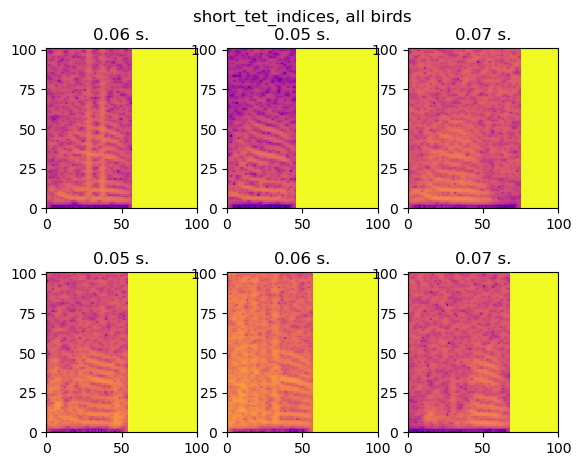

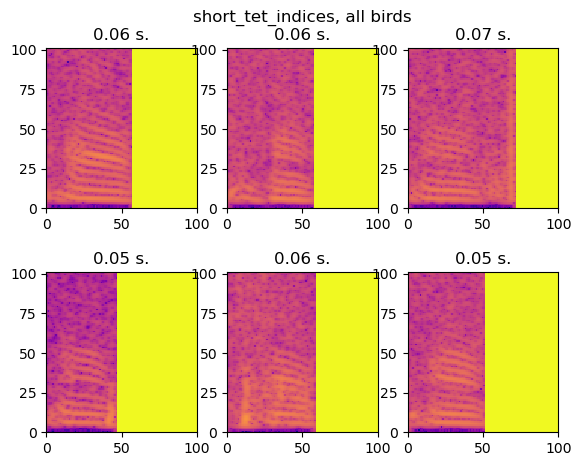

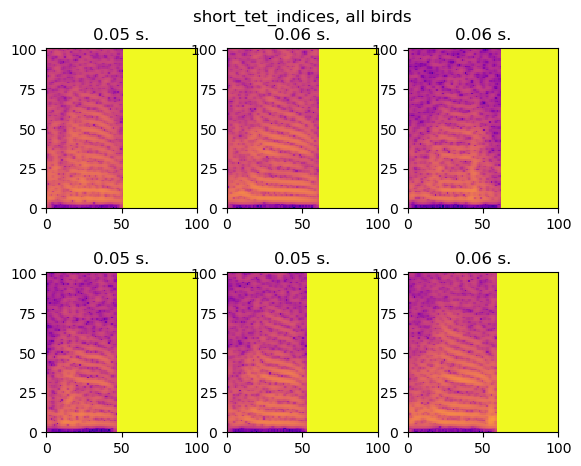

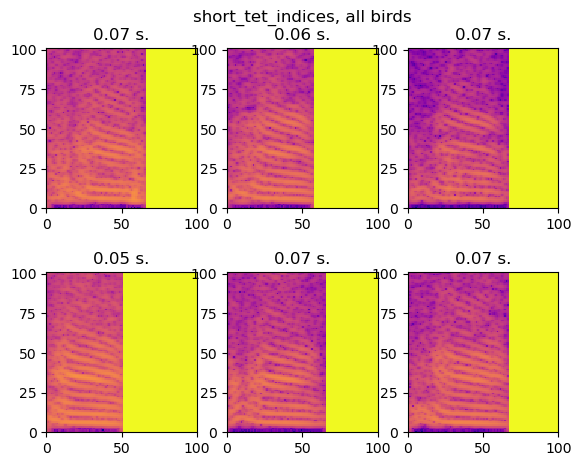

In [20]:
# what are the calls that form the short tets in the female distribution?
# I will plot the spectrogram of the calls that form the
# short tets

# first I need to get the indices of the calls that form the short tets
# I will use the spectrogram dataframe to get the spectrograms of the calls
# I will plot the spectrograms of the calls that form the short tets

# get the indices of the calls that form the short tets
short_tet_indices = list()
long_tet_indices = list()
mid_tet_indices = list()
for i in df.index:
    if df['Bird_ID'][i][-1] == 'F':
        if df['Tags'][i] == '["tet"]':
            if df['length'][i] < 0.075:
                short_tet_indices.append([i, df['SpecInd'][i]])
            elif df['length'][i] > 0.15:
                long_tet_indices.append([i, df['SpecInd'][i]])
            else:
                mid_tet_indices.append([i, df['SpecInd'][i]])

# let's do the same but break it down by bird
# make a dictionary to hold the indices of the calls that form the short tets for each bird
bird_short_tet_indices = dict()
bird_long_tet_indices = dict()
bird_mid_tet_indices = dict()
for bird in df['Bird_ID'].unique():
    bird_short_tet_indices[bird] = list()
    bird_long_tet_indices[bird] = list()
    bird_mid_tet_indices[bird] = list()
    for i in df.index:
        if df['Bird_ID'][i] == bird:
            if df['Tags'][i] == '["tet"]':
                if df['length'][i] < 0.07:
                    bird_short_tet_indices[bird].append([i, df['SpecInd'][i]])
                elif df['length'][i] > 0.15:
                    bird_long_tet_indices[bird].append([i, df['SpecInd'][i]])
                else:
                    bird_mid_tet_indices[bird].append([i, df['SpecInd'][i]])

                    

# get the spectrograms of the calls that form the short tets
# let's plot them in subplots of 6 calls per plot, and make a new plot for each bird
# spec_ind is two numbers, the first is the index of the call in the dataframe, the second is the index of the call in the spectrogram array
for i, spec_ind in enumerate(short_tet_indices[0:24]):
    if i % 6 == 0:
        # space the subplots further apart in the y direction
        fig, axs = plt.subplots(2,3)
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)

        fig.suptitle(f'short_tet_indices, all birds')
        axs[0,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
        axs[0,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')      
    if i % 6 == 1:
        axs[0,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
        axs[0,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')      

    if i % 6 == 2:
        axs[0,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
        axs[0,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
    if i % 6 == 3:
        axs[1,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
        axs[1,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
    if i % 6 == 4:
        axs[1,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
        axs[1,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
    if i % 6 == 5:
        axs[1,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
        axs[1,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
        plt.show()

        

In [21]:
# # get the spectrograms of the calls that form the long tets, and plot them in the same way
# for i, spec_ind in enumerate(long_tet_indices[0:24]):
#     if i % 6 == 0:
#         fig, axs = plt.subplots(2,3)
#         plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
#         fig.suptitle(f'long_tet_indices, all birds')
#         axs[0,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')      
#         axs[0,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         # axs[0,0].set_title(f'i={spec_ind[0]}, index={df.index[spec_ind[0]]} length={df.iloc[spec_ind[0]]["length"]}')
#     if i % 6 == 1:
#         axs[0,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[0,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         # axs[0,1].set_title(f'i={spec_ind[0]}, index={df.index[spec_ind[0]]} length={df.iloc[spec_ind[0]]["length"]}')
#     if i % 6 == 2:
#         axs[0,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[0,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#     if i % 6 == 3:
#         axs[1,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[1,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#     if i % 6 == 4:
#         axs[1,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[1,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#     if i % 6 == 5:
#         axs[1,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[1,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         plt.show()
        

In [22]:
# # get the spectrograms of the calls that form the mid tets, and plot them in the same way
# for i, spec_ind in enumerate(mid_tet_indices[0:24]):
#     if i % 6 == 0:
#         fig, axs = plt.subplots(2,3)
#         plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
#         fig.suptitle(f'medium tets, all birds')
#         axs[0,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')        
#         axs[0,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#     if i % 6 == 1:
#         axs[0,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[0,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#     if i % 6 == 2:
#         axs[0,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[0,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#     if i % 6 == 3:
#         axs[1,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[1,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#     if i % 6 == 4:
#         axs[1,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[1,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#     if i % 6 == 5:
#         axs[1,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#         axs[1,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         plt.show()
        

# ok let's look at this broken down by individual. I'm very interested in the formants that I'm seeing in some, but not all, of the female calls.

In [13]:
# # get the spectrograms of the calls that form the long tets, and plot them in the same way, but only plot the ones that belong to one or other of the female birds
# # so let's plot the calls for each bird separately
# for bird in df['Bird_ID'].unique():
#     for i, spec_ind in enumerate(bird_long_tet_indices[bird][0:24]):
#         if i % 6 == 0:
#             fig, axs = plt.subplots(2,3)
#             plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
#             plt.suptitle(f'{bird} long tets/DCs')
#             axs[0,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')  
#             axs[0,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 1:
#             axs[0,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[0,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 2:
#             axs[0,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[0,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 3:
#             axs[1,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 4:
#             axs[1,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 5:
#             axs[1,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#             plt.show()

# for bird in df['Bird_ID'].unique():
#     for i, spec_ind in enumerate(bird_short_tet_indices[bird][0:24]):
#         if i % 6 == 0:
#             fig, axs = plt.subplots(2,3)
#             plt.suptitle(f'{bird} short tets')
#             plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
#             axs[0,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')   
#             axs[0,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')     
#         if i % 6 == 1:
#             axs[0,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[0,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 2:
#             axs[0,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[0,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 3:
#             axs[1,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 4:
#             axs[1,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 5:
#             axs[1,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#             plt.show()

# for bird in df['Bird_ID'].unique():
#     for i, spec_ind in enumerate(bird_mid_tet_indices[bird][0:24]):
#         if i % 6 == 0:
#             fig, axs = plt.subplots(2,3)
#             plt.suptitle(f'{bird} medium length tets')
#             plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
#             axs[0,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')   
#             axs[0,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')     
#         if i % 6 == 1:
#             axs[0,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[0,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 2:
#             axs[0,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[0,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 3:
#             axs[1,0].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,0].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 4:
#             axs[1,1].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,1].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#         if i % 6 == 5:
#             axs[1,2].pcolormesh(spectrograms[spec_ind[1],:,:], cmap='plasma', shading='auto')
#             axs[1,2].set_title(f'{df.iloc[spec_ind[0]]["length"]:0.2f} s.')
#             plt.show()


# yeah pretty much the most interesting thing going on right now is the power in the formants of the tets and the DCs. Both females 
##  have a lot of power in the formants of their DCs, but the formants of the DCs are a 
### need to figure out where I'm going with this

# ok back to non index bs
# How hard is it going to be to discriminate the tets from the DCs? I may well have to do a multidimensional thing.

In [23]:
# Ok finally I have the things I need. 
# spectrograms, df, and spect_df
# I want to plot the duration of the tets vs the fundamental frequency of the tets

# iterate through the tets in the df, and pull the ff from the spect_df
# then plot the duration vs the ff

# first I need to get the ff from the spect_df
# what is the average length of a tet for each bird? Actually plot the distribution of tet lengths for each bird
tet_lengths = list()
tet_ffs = list()
tet_formants = list()
spect_ind_list = list()
for bird in df['Bird_ID'].unique():
    # tet_lengths = list()
    for i in df.index:
        if df['Bird_ID'][i] == bird:
            if df['Tags'][i] == '["tet"]':
                tet_lengths.append(df['length'][i])
                # find the right index in the spect_df using the project.start_index column
                spect_ind = np.where(spect_df['project.start_index'] == df['SpecInd'][i])[0]
                spect_ind_list.append(spect_ind[0])                # print(f"i = {i} , df['SpecInd'][i] = {df['SpecInd'][i]}, spect_ind: {spect_ind}, spect_df['project.start_index'][spect_ind[0]] = {spect_df['project.start_index'][spect_ind[0]]}")
                # print(f"row: {spect_ind} has spect_df['fund'][spect_ind[0]] = {spect_df['fund'][spect_ind[0]]}")
                # print(spect_ind)
                tet_ffs.append(spect_df['fund'][spect_ind[0]])
                tet_formants.append(spect_df['q1'][spect_ind[0]])
  

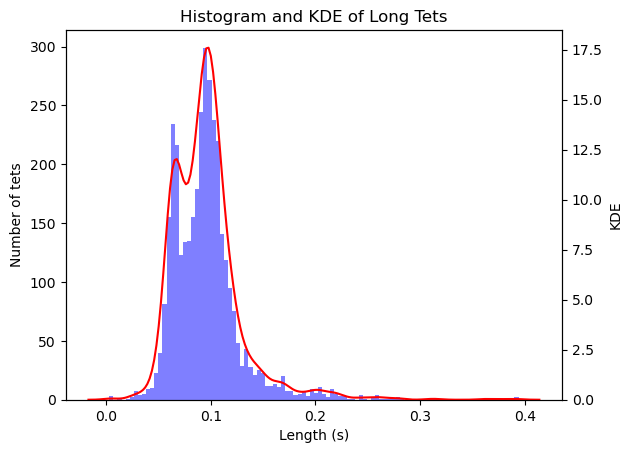

In [24]:

import seaborn as sns

# Create a figure and axes
fig, ax1 = plt.subplots()

# Plot histogram of long tets
ax1.hist(all_tet_lengths, bins=100, color='blue', alpha=0.5)
ax1.set_xlabel('Length (s)')
ax1.set_ylabel('Number of tets')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot KDE of long tets
sns.kdeplot(all_tet_lengths, color='red', ax=ax2)
ax2.set_ylabel('KDE')

# Set labels and title
ax1.set_title('Histogram and KDE of Long Tets')

# Show the plot
plt.show()


In [25]:
spect_df

,Bird,project.start_index,calltype,fund,devfund,cvfund,maxfund,minfund,F1,F2,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,WhiWhi6607F,1134,"[""0""]",602.035277,0.020312,0.123225,676.056338,480.000000,1927.151857,5606.097997,...,13.084285,0.754326,609.375,1031.250,1875.000,0.139157,0.077088,-0.031718,2.037413,0.966456
1,BluGre1214F,951,"[""6""]",532.179639,0.659361,0.171370,592.592593,298.136646,1223.147592,4405.922739,...,5.665965,0.568655,562.500,984.375,2343.750,0.041599,0.021608,-0.048306,1.941768,0.994068
2,BluGre1214F,3202,"[""5""]",1004.070215,-1.918334,1.029701,3428.571429,539.325843,3282.440047,5674.842286,...,2.485675,0.790230,1218.750,3328.125,3750.000,0.021833,0.011271,-0.066505,1.931446,0.993494
3,WhiWhi6607F,2406,"[""6""]",606.338279,0.138851,0.031357,631.578947,564.705882,1153.195682,2492.185919,...,12.816050,0.555701,656.250,1265.625,2437.500,0.049616,0.026952,-0.015422,1.876354,0.998047
4,BroGre1354M,311,"[""5""]",538.920136,0.645045,0.054985,564.705882,484.848485,2085.536237,3634.836575,...,5.098458,0.733783,2156.250,2765.625,3281.250,0.029410,0.016000,-0.036766,1.929756,0.993356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,264,"[""5""]",2759.790084,88.223783,0.410419,3428.571429,640.000000,3032.627721,4153.134038,...,8.838236,0.738755,2859.375,3234.375,3703.125,0.025087,0.011426,-0.194618,2.214188,0.981780
4340,WhiWhi6607F,2596,"[""6""]",578.539703,-0.142540,0.253493,705.882353,342.857143,2424.752958,4687.304451,...,5.164424,0.594936,703.125,1406.250,3421.875,0.081503,0.045225,0.001646,1.840979,0.998115
4341,WhiWhi6607F,2607,"[""6""]",549.876920,-0.126703,0.223594,640.000000,317.880795,1243.568203,2839.879516,...,8.606601,0.563546,656.250,1265.625,2531.250,0.053374,0.029182,0.006879,1.913242,0.995226
4342,BluGre1214F,453,"[""6""]",553.899881,-2.095338,0.032359,578.313253,521.739130,2318.997973,4615.010937,...,3.728708,0.762351,796.875,1687.500,3375.000,0.029430,0.016659,0.009932,1.831353,0.990856


In [26]:
spect_ind[0]

899

In [27]:
spect_df

,Bird,project.start_index,calltype,fund,devfund,cvfund,maxfund,minfund,F1,F2,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,WhiWhi6607F,1134,"[""0""]",602.035277,0.020312,0.123225,676.056338,480.000000,1927.151857,5606.097997,...,13.084285,0.754326,609.375,1031.250,1875.000,0.139157,0.077088,-0.031718,2.037413,0.966456
1,BluGre1214F,951,"[""6""]",532.179639,0.659361,0.171370,592.592593,298.136646,1223.147592,4405.922739,...,5.665965,0.568655,562.500,984.375,2343.750,0.041599,0.021608,-0.048306,1.941768,0.994068
2,BluGre1214F,3202,"[""5""]",1004.070215,-1.918334,1.029701,3428.571429,539.325843,3282.440047,5674.842286,...,2.485675,0.790230,1218.750,3328.125,3750.000,0.021833,0.011271,-0.066505,1.931446,0.993494
3,WhiWhi6607F,2406,"[""6""]",606.338279,0.138851,0.031357,631.578947,564.705882,1153.195682,2492.185919,...,12.816050,0.555701,656.250,1265.625,2437.500,0.049616,0.026952,-0.015422,1.876354,0.998047
4,BroGre1354M,311,"[""5""]",538.920136,0.645045,0.054985,564.705882,484.848485,2085.536237,3634.836575,...,5.098458,0.733783,2156.250,2765.625,3281.250,0.029410,0.016000,-0.036766,1.929756,0.993356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,264,"[""5""]",2759.790084,88.223783,0.410419,3428.571429,640.000000,3032.627721,4153.134038,...,8.838236,0.738755,2859.375,3234.375,3703.125,0.025087,0.011426,-0.194618,2.214188,0.981780
4340,WhiWhi6607F,2596,"[""6""]",578.539703,-0.142540,0.253493,705.882353,342.857143,2424.752958,4687.304451,...,5.164424,0.594936,703.125,1406.250,3421.875,0.081503,0.045225,0.001646,1.840979,0.998115
4341,WhiWhi6607F,2607,"[""6""]",549.876920,-0.126703,0.223594,640.000000,317.880795,1243.568203,2839.879516,...,8.606601,0.563546,656.250,1265.625,2531.250,0.053374,0.029182,0.006879,1.913242,0.995226
4342,BluGre1214F,453,"[""6""]",553.899881,-2.095338,0.032359,578.313253,521.739130,2318.997973,4615.010937,...,3.728708,0.762351,796.875,1687.500,3375.000,0.029430,0.016659,0.009932,1.831353,0.990856


In [28]:
df

,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords,Bird_ID,StartIndex_in_sec,EndIndex_in_sec,length,SpecInd
Unnamed: 0,,,,,,,,,,,,
0,BroGre1354M,0,705034,709502,"[""tet""]",0.0,[11.813441 10.158026 8.204752],BroGre1354M,14.688208,14.781292,0.093083,3704
1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.289108 8.867108 3.8716762],BluGre1214F,15.398354,15.454500,0.056146,2798
2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[9.031709 7.9875793 2.4193041],BluGre1214F,16.121896,16.174354,0.052458,751
3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.432616 8.651451 3.9261248],BluGre1214F,17.601896,17.678292,0.076396,1932
4,BroGre1354M,0,910549,913839,"[""tet""]",4.0,[10.93499 7.944698 0.92982405],BroGre1354M,18.969771,19.038312,0.068542,2911
...,...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,3,297302736,297305283,"[""tet""]",4.0,[12.446056 7.7917695 2.9063237],WhiWhi1541M,6193.807000,6193.860062,0.053062,1300
4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.918158 10.1539955 3.8789632],BluGre1214F,6194.266917,6194.354250,0.087333,1859
4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[14.02288 10.04855 4.029904],BluGre1214F,6195.145854,6195.242583,0.096729,1536


In [29]:
# # plot the first 10 spectrograms
# for i in range(10):
#     ind = df.index[i]
#     spec_ind_test = df.iloc[i]['SpecInd']
#     spec_ind = np.where(h5_indices == ind)[0][0]
#     assert(spec_ind == spec_ind_test)
#     spectrogram = spectrograms[spec_ind,:,:]
#     plt.figure()
#     plt.pcolormesh(spectrogram, cmap='plasma', shading='auto')
#     plt.title(f'i={i}, index={df.index[i]} length={df.iloc[i]["length"]}')
#     plt.colorbar()
#     plt.show()

In [30]:
df['Tags'].unique()

array(['["tet"]', '["hat"]', '["3"]', '["call"]', '["DC"]', '["WF"]',
       '["-2"]', '["8"]', '["2"]'], dtype=object)

In [31]:
# # plot spectrograms of dcs
# j = 0
# for i in range(len(df)):
#     ii = df.index[i]
#     if df['Tags'][ii] == '["DC"]':
# # plot the first 10 spectrograms
#         ind = df.index[i]
#         spec_ind = np.where(h5_indices == ind)[0][0]
#         spectrogram = spectrograms[spec_ind,:,:]
#         plt.figure()
#         plt.pcolormesh(spectrogram, cmap='plasma', shading='auto')
#         plt.title(f'i={i}, index={df.index[i]} length={df.iloc[i]["length"]}')
#         plt.colorbar()
#         plt.show()
#         j += 1
#         if j > 10:
#             break

In [32]:
# # plot some spectrograms of the long tets
# for i in range(10):
#     plt.figure(figsize=(10, 5))
#     plt.pcolormesh(spectrograms[long_tet_index[i]], cmap='plasma', shading='auto')
#     plt.title(f'Long tet {i}')
#     plt.xlabel('t (sec)')
#     plt.ylabel('Frequency (Hz)')
#     plt.grid()
#     plt.show()